**1. Exploratory data analysis**

Let's install librosa using the pip package. This will ensure that all required dependencies are installed. 

In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the wav**

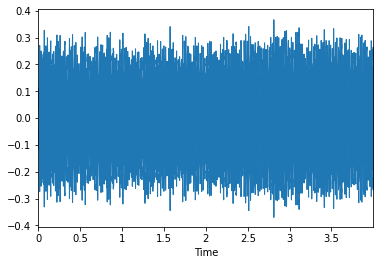

In [ ]:
file_name='/content/drive/MyDrive/UrbanSound/UrbanSound8K/audio/fold10/102857-5-0-30.wav'

audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveplot(audio_data,sr=sampling_rate)
ipd.Audio(file_name)

In [ ]:
audio_data

array([ 0.04068299,  0.04615064,  0.03444541, ..., -0.03091545,
       -0.02421082, -0.01935888], dtype=float32)

In mono, there is only one signal. So, the results from our audio_data show that librosa has converted the audio into integers with only 1-dimension.

In [ ]:
sampling_rate

22050

Librosa is an open-source python package for music and audio analysis. The library is able to give us the data and the sampling rate. By default, librosa mixes all audio to mono and resamples them to 22050 Hz at load time. This plays a very important role as in audio, different sounds have different sample rates.

Let's use the Pandas library to read our csv file



In [ ]:
audio_dataset_path='/content/drive/MyDrive/UrbanSound/UrbanSound8K/audio'
metadata=pd.read_csv('/content/drive/MyDrive/UrbanSound/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Let's check whether the dataset is imbalanced

In [ ]:
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

Most of the classes in the dataset are balanced. Thus, this would be a good dataset to use.

**2. Data preprocessing**

To extract the features, we will be using the Mel-Frequency Cepstral Coefficients (MFCC) algorithm. This algorithm summarizes the frequency distribution across the window size. This enables the analysis of both the frequency and time characteristics of the sound. It will enable us identify features for classification.

In [ ]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)

In [ ]:
mfccs

array([[-154.44733   , -154.69261   , -152.6176    , ..., -154.42194   ,
        -155.35812   , -147.7961    ],
       [ 104.936646  ,  113.95514   ,  112.2651    , ...,  111.61168   ,
         111.62954   ,  112.5724    ],
       [  -9.436067  ,  -17.30145   ,  -22.981655  , ...,  -19.326853  ,
         -17.715397  ,  -22.694584  ],
       ...,
       [  -0.95698977,    1.7471615 ,    6.766102  , ...,    5.033868  ,
           8.724199  ,    5.152764  ],
       [  -1.8740845 ,   -1.0185362 ,    1.8260009 , ...,   -1.4835715 ,
          -1.8088813 ,   -3.622932  ],
       [   5.5275526 ,    5.860734  ,    5.689728  , ...,    8.39476   ,
           7.0794287 ,    6.855796  ]], dtype=float32)

In [ ]:
data1=pd.read_csv("/content/drive/MyDrive/FlaskApp/my_csv_org.csv")

In [ ]:
data2=data1.drop(["Unnamed: 0"], axis=1)

In [ ]:
import json

In [ ]:
for i in range(0,8731):
  b=[]
  b= json.loads(data2["feature"][i])
  arr=np.array(b,dtype="float32")
  data2["feature"][i]=arr

In [ ]:
type(data2["feature"][0])

numpy.ndarray

These are patterns that have been extracted from the audio based on the frequency and time characteristics.

In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [ ]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [24:57,  1.84it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8326it [57:00,  2.37it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
8329it [57:01,  3.16it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8407it [57:30,  2.81it/s]

In [ ]:
type(extracted_features[0])

list

In [ ]:
extracted_features[1]

[array([-4.23731110e+02,  1.09229897e+02, -5.28725967e+01,  6.08275375e+01,
         3.48053306e-01,  1.72516479e+01,  2.17315149e+00,  1.06253052e+01,
        -1.37355554e+00,  1.22368011e+01, -1.11380310e+01,  2.10162849e+01,
        -9.42663097e+00,  1.34838581e+01, -1.54741585e-01,  7.12285709e+00,
        -2.99405336e+00,  1.13444920e+01, -6.27536583e+00,  6.80403280e+00,
        -2.84533548e+00,  8.71153069e+00, -2.30935645e+00,  8.37316990e+00,
        -1.61044824e+00,  1.25689733e+00, -4.38749790e+00,  1.21991181e+00,
        -6.12156153e+00,  8.37000608e-01, -1.00008357e+00,  1.86459708e+00,
        -9.34978485e-01,  4.42659557e-02,  1.10608805e-02, -1.15159713e-01,
        -1.59411800e+00,  5.19475758e-01, -5.57760537e-01,  4.20229554e-01],
       dtype=float32), 'children_playing']

Let's convert the entire list into a dataframe using the Pandas library.

In [ ]:
extracted_features_df=data2
extracted_features_df.head(10)

,feature,class
0,"[-214.95764, 70.502464, -130.70279, -53.116936...",dog_bark
1,"[-423.7311, 109.2299, -52.872597, 60.827538, 0...",children_playing
2,"[-458.52844, 121.35432, -46.535675, 51.969467,...",children_playing
3,"[-413.63254, 101.61351, -35.43868, 53.047146, ...",children_playing
4,"[-446.38693, 113.68634, -52.4572, 60.349724, 2...",children_playing
5,"[-446.64075, 116.91874, -33.8149, 55.398895, 2...",children_playing
6,"[-476.23175, 119.29175, -28.403315, 55.855236,...",children_playing
7,"[-463.81815, 116.27937, -28.78479, 49.436337, ...",children_playing
8,"[-471.1096, 125.35387, -37.010067, 57.4828, -1...",children_playing
9,"[-195.59555, 114.13017, -13.902405, 0.56244934...",car_horn


We now split the dataset into independent and dependent dataset

In [ ]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(8732, 40)

In [ ]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [ ]:
y.shape

(8732,)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

We perform a train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

**3. Model creation**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
num_labels=y.shape[1]

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4100      
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
202/219 [==========================>...] - ETA: 0s - loss: 10.0151 - accuracy: 0.1173
Epoch 1: val_loss improved from inf to 2.28725, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 2s 5ms/step - loss: 9.4852 - accuracy: 0.1190 - val_loss: 2.2872 - val_accuracy: 0.1025
Epoch 2/200
209/219 [===========================>..] - ETA: 0s - loss: 2.5718 - accuracy: 0.1225
Epoch 2: val_loss improved from 2.28725 to 2.28055, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.5646 - accuracy: 0.1220 - val_loss: 2.2806 - val_accuracy: 0.1030
Epoch 3/200
204/219 [==========================>...] - ETA: 0s - loss: 2.3326 - accuracy: 0.1369
Epoch 3: val_loss improved from 2.28055 to 2.26409, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.3309 - accuracy: 0.1393 - val_loss: 2.2641 - val_accuracy: 0.116

In [ ]:
#relu accuracy
 #test_accuracy=model.evaluate(X_test,y_test,verbose=0)
#print(test_accuracy[1])

0.11161991953849792


In [ ]:
#softmax accuracy
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7710360884666443


In [ ]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

55/55 [==============================] - 0s 2ms/step


In [ ]:
predict_x

array([[5.66422733e-12, 4.43129218e-04, 4.57478180e-08, ...,
        7.01628869e-06, 6.34702701e-07, 6.09023846e-06],
       [1.22677515e-37, 9.99997199e-01, 5.54518113e-16, ...,
        9.43658686e-25, 9.04314212e-18, 2.74604122e-06],
       [4.09345329e-02, 8.34126025e-03, 1.82461753e-01, ...,
        6.72923867e-04, 1.29256710e-01, 5.76002933e-02],
       ...,
       [4.73287702e-02, 1.01994295e-02, 6.20318428e-02, ...,
        4.71421052e-03, 1.01526156e-02, 6.29780948e-01],
       [2.35540983e-06, 5.46634074e-05, 9.15313558e-06, ...,
        5.01465460e-13, 2.27844372e-04, 4.93569626e-03],
       [3.48626240e-03, 1.83892180e-03, 3.74034047e-01, ...,
        1.74331808e-06, 1.58760086e-01, 2.07336247e-02]], dtype=float32)

In [ ]:
classes_x

array([4, 1, 5, ..., 9, 3, 2])

**4. Testing the model**

[-1.9559555e+02  1.1413017e+02 -1.3902405e+01  5.6244934e-01
 -2.0187422e+01 -4.6002421e+00 -4.0748325e+01  4.3164859e+00
 -1.9054279e+01 -2.9072421e+00 -1.9817862e+01  7.6085382e+00
 -2.1783587e+01 -3.9304407e+00 -2.0164593e+01  4.9374194e+00
 -1.4870395e+01  1.0587921e+00 -1.4128366e+01  8.8029366e+00
 -6.7196050e+00  6.5456376e+00 -4.7356715e+00  6.4181215e-01
 -9.7270451e+00 -2.5774780e-01 -8.7330179e+00 -6.0123557e-01
 -6.9120641e+00  5.1001887e+00 -1.0137573e+01 -1.8843290e-01
 -2.8157558e+00  4.4949040e+00 -7.4790506e+00 -4.4629035e+00
 -1.9973911e+00  3.8520319e+00 -5.9989591e+00 -1.0038447e+00]
[[-1.9559555e+02  1.1413017e+02 -1.3902405e+01  5.6244934e-01
  -2.0187422e+01 -4.6002421e+00 -4.0748325e+01  4.3164859e+00
  -1.9054279e+01 -2.9072421e+00 -1.9817862e+01  7.6085382e+00
  -2.1783587e+01 -3.9304407e+00 -2.0164593e+01  4.9374194e+00
  -1.4870395e+01  1.0587921e+00 -1.4128366e+01  8.8029366e+00
  -6.7196050e+00  6.5456376e+00 -4.7356715e+00  6.4181215e-01
  -9.7270451e+00 

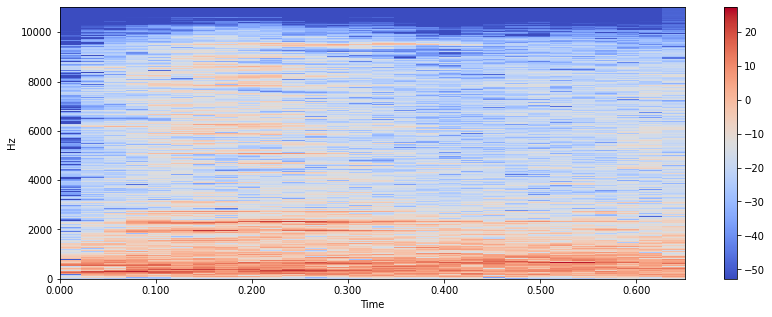

In [ ]:
filename="/content/drive/MyDrive/UrbanSound/UrbanSound8K/audio/fold10/100648-1-0-0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=22050, x_axis='time', y_axis='hz')
plt.colorbar()
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
print('\n')
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
print(prediction_class)
ipd.Audio(filename)